In [1]:
%run supervised_functions.ipynb

# Generate data

In [2]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [3]:
np.random.seed(42)

N = 100000
steps = 5

df_list = []
final_shape = 0
smiles_per_random_sample = 1000
pool_chunk_size = 10

# Create dataset for multi-step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,))

        for new_df in p.imap_unordered(functools.partial(generate_train_data, steps=steps), smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

108306it [02:00, 896.62it/s]                                                                         


(108306, 10)
(108306, 10)


# Neural Network!

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

%time train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

Epoch 1, Loss: 23433.7715
Epoch 2, Loss: 13453.0000
Epoch 3, Loss: 4567.4375
Epoch 4, Loss: 1058.8438
Epoch 5, Loss: 364.7165
Epoch 6, Loss: 258.4317
Epoch 7, Loss: 251.2782
Epoch 8, Loss: 248.9837
Epoch 9, Loss: 244.6840
Epoch 10, Loss: 246.2561

FINAL TEST LOSS: 65.92863464355469
CPU times: user 7.36 s, sys: 899 ms, total: 8.26 s
Wall time: 4.21 s


NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

# Embedding type 2 - GIN training using attribute masking on clintox

In [6]:
model_name = "models/zinc2m_gin.pth"
gin_model = torch.load(model_name).to(device)

In [7]:
batch_size = 1024
X = []
for i in tqdm.tqdm(range(0, int(main_df.shape[0]*0.8), batch_size)):
    reactants = main_df["reactant"][i:i+batch_size]
    products = main_df["product"][i:i+batch_size]
    X.append(torch.concatenate([get_mol_embedding(gin_model, reactants), get_mol_embedding(gin_model, products)], axis=1))
X = torch.concatenate(X, axis=0)
emb_len = X.shape[1]//2
X.shape

  0%|                                                                         | 0/85 [00:00<?, ?it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
  4%|██▎                                                              | 3/85 [00:11<05:15,  3.85s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
 11%|██████▉                                                          | 9/85 [00:36<05:11,  4.10s/it]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py

torch.Size([87040, 256])

In [8]:
Y = []
for i in tqdm.tqdm(range(0, int(main_df.shape[0]*0.8), batch_size)):
    Y.append(get_action_embedding(gin_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]]))
Y = torch.concatenate(Y)
Y.shape

100%|████████████████████████████████████████████████████████████████| 85/85 [03:17<00:00,  2.33s/it]


torch.Size([87040, 256])

### MSE training

In [9]:
model = train(X, Y, hidden_size=500, num_hidden=3, lr=1e-3, epochs=100)

Epoch 1, Loss: 0.0922
Epoch 2, Loss: 0.0796
Epoch 3, Loss: 0.0698
Epoch 4, Loss: 0.0618
Epoch 5, Loss: 0.0559
Epoch 6, Loss: 0.0510
Epoch 7, Loss: 0.0475
Epoch 8, Loss: 0.0460
Epoch 9, Loss: 0.0442
Epoch 10, Loss: 0.0402
Epoch 11, Loss: 0.0372
Epoch 12, Loss: 0.0359
Epoch 13, Loss: 0.0344
Epoch 14, Loss: 0.0326
Epoch 15, Loss: 0.0317
Epoch 16, Loss: 0.0302
Epoch 17, Loss: 0.0293
Epoch 18, Loss: 0.0292
Epoch 19, Loss: 0.0277
Epoch 20, Loss: 0.0268
Epoch 21, Loss: 0.0259
Epoch 22, Loss: 0.0248
Epoch 23, Loss: 0.0237
Epoch 24, Loss: 0.0231
Epoch 25, Loss: 0.0223
Epoch 26, Loss: 0.0213
Epoch 27, Loss: 0.0214
Epoch 28, Loss: 0.0212
Epoch 29, Loss: 0.0207
Epoch 30, Loss: 0.0203
Epoch 31, Loss: 0.0203
Epoch 32, Loss: 0.0197
Epoch 33, Loss: 0.0188
Epoch 34, Loss: 0.0183
Epoch 35, Loss: 0.0178
Epoch 36, Loss: 0.0173
Epoch 37, Loss: 0.0170
Epoch 38, Loss: 0.0171
Epoch 39, Loss: 0.0167
Epoch 40, Loss: 0.0166
Epoch 41, Loss: 0.0163
Epoch 42, Loss: 0.0160
Epoch 43, Loss: 0.0161
Epoch 44, Loss: 0.01

In [10]:
torch.save(model, "datasets/my_uspto/supervised_zinc_gin/mse_model.pth")

In [11]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

action_embeddings = get_action_dataset_embeddings(gin_model)
print(action_embeddings.shape)

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ru`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_

torch.Size([89384, 256])


### Back to modeling

In [12]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = []
correct_action_dataset_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_applicable_indices.append(correct_app_idx)
        correct_action_dataset_indices.append(correct_act_idx)

100%|███████████████████████████████████████████████████████| 108306/108306 [04:18<00:00, 418.95it/s]


In [13]:
pred = model(torch.Tensor(X[int(main_df.shape[0]*0.8):]).to(device)).detach()
l = []
total = []
for i in tqdm.tqdm(range(pred.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[int(main_df.shape[0]*0.8)+i]], correct_applicable_indices[int(main_df.shape[0]*0.8)+i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance="euclidean")
    l.append(rank.item())
    total.append(act_emb_for_i.shape[0])
print(f"{np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|████████████████████████████████████████████████████████████| 396/396 [00:00<00:00, 2666.88it/s]

99.63888888888889(295.29545454545456) +- 277.12641319746973  


In [14]:
train_idx = np.arange(0, int(X.shape[0]*0.8))
test_idx = np.arange(int(X.shape[0]*0.8), X.shape[0])

In [15]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)

CPU times: user 6min 25s, sys: 20.5 s, total: 6min 46s
Wall time: 6min 25s


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.25it/s]
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541035/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  


3.895602(1)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  1 │ 4.82443 │  0.772386 │         56.8926 │         192.59 │        332.528 │         50.3783 │        177.042 │        332.528 │ 6.98 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.65it/s]


BEST MODEL UPDATED! BEST RANK = 56.89263556985294
3.530276(2)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  2 │ 4.86547 │  0.779425 │         57.0268 │        196.739 │        332.528 │         50.3857 │        180.222 │        332.528 │ 6.57 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.57it/s]


2.815106(3)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  3 │ 4.84113 │  0.782479 │         55.5047 │        191.361 │        332.528 │         49.1412 │        177.997 │        332.528 │ 6.12 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.13it/s]


BEST MODEL UPDATED! BEST RANK = 55.504710477941174
2.206934(4)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  4 │ 4.75191 │   0.78577 │         53.1799 │        184.932 │        332.528 │         46.9295 │        171.961 │        332.528 │ 6.17 min                │
╘════╧═════════╧═══════════╧═════════════════╧═══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.85it/s]


BEST MODEL UPDATED! BEST RANK = 53.179859834558826
2.552700(5)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  5 │ 4.87516 │  0.783121 │         53.9339 │        187.608 │        332.528 │         48.5634 │        175.179 │        332.528 │ 6.34 min                │
╘════╧═════════╧═══════════╧═════════════════╧═══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.46it/s]


2.512956(6)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  6 │ 4.95056 │  0.781671 │         55.2809 │        190.985 │        332.528 │         50.1293 │        181.256 │        332.528 │ 6.54 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.03it/s]


2.610003(7)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  7 │ 4.86456 │  0.783239 │         54.7112 │        193.292 │        332.528 │         48.0629 │        176.986 │        332.528 │ 6.50 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.34it/s]


2.073593(8)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  8 │ 4.61762 │  0.793222 │         52.2396 │        187.566 │        332.528 │         46.1583 │        176.877 │        332.528 │ 6.47 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.12it/s]


BEST MODEL UPDATED! BEST RANK = 52.239602481617645
3.432475(9)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  9 │ 4.60934 │  0.797136 │         51.0662 │        187.676 │        332.528 │         45.4163 │         176.61 │        332.528 │ 6.63 min                │
╘════╧═════════╧═══════════╧═════════════════╧═══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.50it/s]


BEST MODEL UPDATED! BEST RANK = 51.066233915441174
5.807069(10)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 10 │ 4.6082 │  0.795015 │         54.3618 │        191.921 │        332.528 │         48.1123 │        181.204 │        332.528 │ 6.54 min                │
╘════╧════════╧═══════════╧═════════════════╧═══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.34it/s]


4.009817(11)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 11 │ 4.57113 │   0.79698 │         53.8554 │        191.063 │        332.528 │         46.9677 │        177.879 │        332.528 │ 6.50 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.65it/s]


2.732817(12)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 12 │ 4.49258 │  0.799747 │         52.2628 │         188.59 │        332.528 │         45.3824 │        175.239 │        332.528 │ 6.49 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.65it/s]


2.231352(13)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 13 │ 4.5785 │   0.79494 │         53.9155 │        193.767 │        332.528 │         47.3788 │        180.877 │        332.528 │ 6.46 min                │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.08it/s]


2.116151(14)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 14 │ 4.57813 │    0.7982 │         55.4111 │        194.439 │        332.528 │         48.8683 │        185.263 │        332.528 │ 6.36 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.73it/s]


3.231325(15)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 15 │ 4.49837 │  0.799985 │          54.043 │        191.335 │        332.528 │         47.4945 │        181.499 │        332.528 │ 6.37 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.35it/s]


2.113378(16)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 16 │ 4.45225 │  0.802848 │         55.2397 │        195.069 │        332.528 │         48.0039 │        180.314 │        332.528 │ 6.51 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.33it/s]


1.974088(17)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 17 │ 4.42807 │  0.803541 │         53.6399 │        188.153 │        332.528 │         45.4488 │        173.106 │        332.528 │ 6.56 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.56it/s]


4.134337(18)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 18 │ 4.48961 │  0.800992 │         55.7075 │        198.722 │        332.528 │         48.5404 │        184.786 │        332.528 │ 6.52 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.12it/s]


4.828994(19)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 19 │ 4.40181 │   0.80123 │         53.0466 │        191.664 │        332.528 │          44.905 │        176.449 │        332.528 │ 6.44 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.76it/s]


2.088607(20)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 20 │ 4.35423 │  0.805107 │         54.0427 │        193.592 │        332.528 │          45.388 │        177.053 │        332.528 │ 6.50 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.37it/s]


3.683765(21)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 21 │ 4.36489 │  0.806331 │         55.2399 │         198.21 │        332.528 │          46.924 │        183.486 │        332.528 │ 6.58 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:06<00:00,  7.12it/s]


4.886047(22)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 22 │ 4.43949 │   0.79906 │         54.3236 │        196.079 │        332.528 │         45.4204 │        179.665 │        332.528 │ 6.43 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.70it/s]


4.602677(23)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 23 │ 4.38459 │  0.804395 │         54.2998 │        197.208 │        332.528 │         44.8273 │        179.186 │        332.528 │ 6.57 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.98it/s]


5.602087(24)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 24 │ 4.42462 │  0.802459 │         56.2281 │        201.254 │        332.528 │         46.4503 │        182.864 │        332.528 │ 6.36 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.81it/s]


4.759827(25)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 25 │ 4.41922 │   0.80328 │         53.9557 │        194.878 │        332.528 │         45.1106 │        179.481 │        332.528 │ 6.49 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.45it/s]


5.048408(26)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 26 │ 4.45735 │  0.804355 │         55.6897 │        200.568 │        332.528 │         47.3361 │        183.468 │        332.528 │ 6.53 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.35it/s]


2.531490(27)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 27 │ 4.42873 │  0.802414 │         53.0789 │        194.881 │        332.528 │         44.0474 │        176.826 │        332.528 │ 6.54 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.22it/s]


6.259762(28)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 28 │ 4.28003 │  0.808038 │         53.4945 │        191.845 │        332.528 │         44.1445 │        173.241 │        332.528 │ 6.41 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.11it/s]


1.989843(29)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 29 │ 4.3055 │  0.809254 │         54.1224 │        193.281 │        332.528 │         45.2887 │        174.444 │        332.528 │ 6.39 min                │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧══════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.07it/s]


4.067031(30)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 30 │ 4.38746 │   0.80688 │         52.2066 │        186.422 │        332.528 │         43.8352 │        169.628 │        332.528 │ 6.48 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.57it/s]


5.873691(31)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 31 │ 4.33352 │   0.80932 │            55.4 │        196.771 │        332.528 │         46.0318 │        179.211 │        332.528 │ 6.36 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.88it/s]


3.916517(32)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 32 │ 4.27326 │  0.811732 │         53.4426 │        196.528 │        332.528 │         44.6171 │        180.559 │        332.528 │ 6.41 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.08it/s]


5.474151(33)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 33 │ 4.34279 │    0.8071 │         54.7131 │        198.838 │        332.528 │         44.9956 │        179.953 │        332.528 │ 6.49 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.19it/s]


4.550170(34)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 34 │ 4.36034 │  0.809809 │         52.9046 │        191.204 │        332.528 │         43.8396 │        174.093 │        332.528 │ 6.35 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.74it/s]


5.468933(35)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 35 │ 4.26017 │  0.812103 │         54.1637 │        193.163 │        332.528 │         44.6072 │        175.974 │        332.528 │ 6.36 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.48it/s]


3.585291(36)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 36 │ 4.22325 │  0.816352 │         50.3404 │        182.137 │        332.528 │         41.7257 │        164.742 │        332.528 │ 6.52 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.03it/s]


BEST MODEL UPDATED! BEST RANK = 50.34036075367647
4.911014(37)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 37 │ 4.26616 │  0.813759 │         52.2921 │        190.281 │        332.528 │         43.3384 │        170.121 │        332.528 │ 6.51 min                │
╘════╧═════════╧═══════════╧═════════════════╧═══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.07it/s]


5.832989(38)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 38 │ 4.39423 │  0.805293 │         54.9994 │        196.865 │        332.528 │         45.5998 │        176.484 │        332.528 │ 6.52 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.53it/s]


5.991335(39)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 39 │ 4.23943 │  0.814406 │         53.4168 │        191.506 │        332.528 │         42.4586 │        168.063 │        332.528 │ 6.53 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.73it/s]


4.502915(40)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 40 │ 4.26186 │  0.813121 │         51.5985 │        188.513 │        332.528 │         41.4719 │         165.66 │        332.528 │ 6.52 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.70it/s]


1.444632(41)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 41 │ 4.30121 │  0.812389 │         49.4663 │        181.263 │        332.528 │         40.8755 │        161.247 │        332.528 │ 6.38 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.50it/s]


BEST MODEL UPDATED! BEST RANK = 49.46633731617647
5.988136(42)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 42 │ 4.31327 │  0.811117 │          51.528 │        188.572 │        332.528 │         41.6747 │        167.047 │        332.528 │ 6.56 min                │
╘════╧═════════╧═══════════╧═════════════════╧═══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.40it/s]


3.934031(43)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 43 │ 4.25161 │  0.814375 │         53.8207 │        196.521 │        332.528 │         43.2871 │        174.112 │        332.528 │ 6.52 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.95it/s]


4.332134(44)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 44 │ 4.28401 │  0.811778 │         50.5977 │        185.873 │        332.528 │         40.4361 │        161.741 │        332.528 │ 6.39 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.70it/s]


4.972746(45)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 45 │ 4.26709 │  0.812595 │         52.8089 │        188.869 │        332.528 │         42.7942 │        165.513 │        332.528 │ 6.41 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.43it/s]


4.492398(46)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 46 │ 4.20625 │  0.815987 │         49.2834 │        181.276 │        332.528 │         38.6583 │        157.116 │        332.528 │ 6.45 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.05it/s]


BEST MODEL UPDATED! BEST RANK = 49.28343290441177
4.872534(47)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 47 │ 4.27465 │  0.809286 │         50.9212 │        187.055 │        332.528 │         39.7312 │        160.924 │        332.528 │ 6.61 min                │
╘════╧═════════╧═══════════╧═════════════════╧═══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:06<00:00,  7.28it/s]


3.664834(48)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 48 │ 4.29034 │   0.81079 │         49.8404 │        181.408 │        332.528 │         40.4644 │         161.02 │        332.528 │ 6.50 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.04it/s]


3.332379(49)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 49 │ 4.23406 │  0.814565 │         48.9663 │        180.352 │        332.528 │         39.4416 │        159.361 │        332.528 │ 6.64 min                │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.18it/s]


BEST MODEL UPDATED! BEST RANK = 48.96627987132353
4.708753(50)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 50 │ 4.15833 │  0.820054 │         48.5949 │        180.259 │        332.528 │          38.978 │        157.865 │        332.528 │ 6.53 min                │
╘════╧═════════╧═══════════╧═════════════════╧═══════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.10it/s]


BEST MODEL UPDATED! BEST RANK = 48.594898897058826


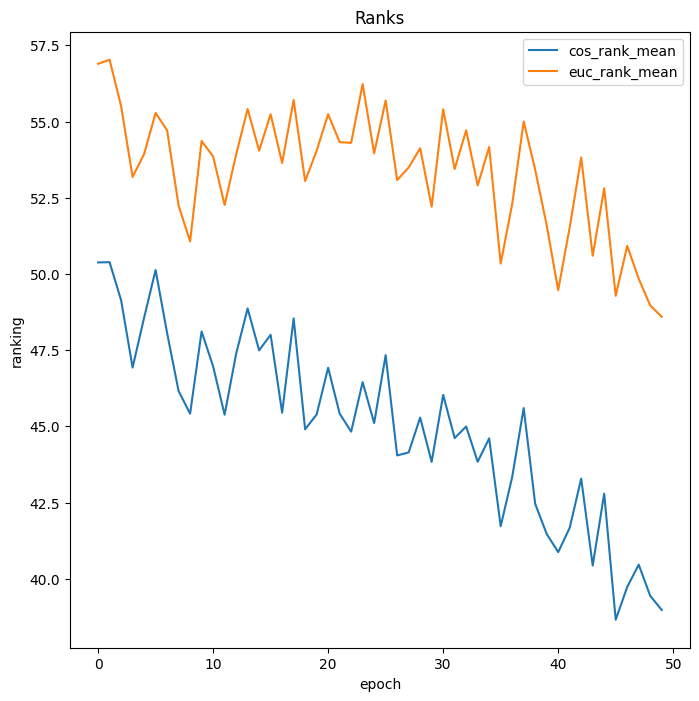

In [16]:
lr = 1e-3
epochs = 50
batch_size = 128


for distance_metric, negative_method, topk, emb_model_update in itertools.product(["euclidean"], ["all"], [10], [1]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    
    best_rank = 10000
    best_model = None
    
    model = PolicyNetwork().to(device)
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    criterion = WeightedRegularizedTriplet()
    
    action_embeddings = get_action_dataset_embeddings(embedding_model)
    action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)
    
    metric_dict = {"cos_rank_mean": [], "euc_rank_mean": [], "cos_rank_std": [], "euc_rank_std": [], 
                   "cos_rank_tot": [], "euc_rank_tot": [], "rmse": [], "cos_sim": [], "time(epoch_start-now)": []}
    # Train the model
    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
            outputs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size])

            # Calc negatives
            negatives = []
            
            for _i in range(outputs.shape[0]):
                curr_out = outputs[_i].detach()

                if negative_method == "applicable":
                    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_applicable_indices[train_idx[i+_i]]
                    top = get_top_k_indices(curr_out, act_emb_for_i, correct_applicable_index, distance=distance_metric, k=50)
                    negatives.append(act_emb_for_i[top])
                
                elif negative_method == "all":
                    correct_action_dataset_index = correct_action_dataset_indices[train_idx[i+_i]]
                    if distance_metric == "euclidean":
                        dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)
                    elif distance_metric == "cosine":
                        dist = (1 - action_embeddings.dot(curr_out)) / (action_embeddings_norm *torch.linalg.norm(curr_out))
                    sorted_idx = torch.argsort(dist)[:topk] # get topk
                    sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
                    negatives.append(action_embeddings[sorted_idx])
                        
            negatives = torch.Tensor(torch.concatenate(negatives, axis=0)).to(device)
                                
            # get targets
            targets = torch.Tensor(get_action_embedding(embedding_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]])).to(device)
                                
            # Calc loss
            inputs = torch.concat([outputs, targets, negatives])
            labels = torch.concat([torch.arange(outputs.shape[0]), torch.arange(targets.shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
            loss = criterion(inputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('{:.6f}({})'.format(loss.item(), epoch), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# emb_model_update = {emb_model_update} | -ve_method = {negative_method} | dist_metric = {distance_metric} | topk = {topk} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_reactants, test_products).detach()
            true = get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

            metric_df = pd.DataFrame(columns=["rmse", "cos_sim", "euc_rank_mean", "euc_rank_std", "euc_rank_tot", "cos_rank_mean", "cos_rank_std", "cos_rank_tot", "time(epoch_start-now)"])

            # Print Test metrics
            metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean().item() )
            metric_dict["cos_sim"].append( ((pred*true).sum(axis=1) / torch.linalg.norm(pred, axis=1) / torch.linalg.norm(true, axis=1)).mean().item() )

            # Print Test metric - Rank
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_applicable_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance=dist)
                    l.append(rank.item())
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                metric_dict[f"{dist[:3]}_rank_mean"].append(np.mean(l))
                metric_dict[f"{dist[:3]}_rank_std"].append(np.std(l))
                metric_dict[f"{dist[:3]}_rank_tot"].append(np.mean(total))

            metric_dict["time(epoch_start-now)"].append(f"{(time.time()-start_time)/60:.2f} min")
            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
        # Update embedding model and action_embeddings
        if epoch % emb_model_update == 0:
            embedding_model.load_state_dict(model.GIN.state_dict())
            action_embeddings = get_action_dataset_embeddings(embedding_model)
            action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

        # Update best model
        if metric_dict["euc_rank_mean"][-1] < best_rank:
            best_rank = metric_dict["euc_rank_mean"][-1]
            best_model = type(model)()
            best_model.load_state_dict(model.state_dict())
            best_epoch = epoch
            print(f"BEST MODEL UPDATED! BEST RANK = {best_rank}")
            
    fig = plt.figure(figsize=(8, 8))
    for dist in filter(lambda x: "mean" in x, metric_dict.keys()):
        plt.plot(metric_dict[dist], label=dist)
    plt.title("Ranks")
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.legend()
    fig.show()
    
    # save everything
    folder = f"models/supervised/{steps}step/emb_model_update={emb_model_update}||-ve_method={negative_method}||dist_metric={distance_metric}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
    fig.savefig(os.path.join(folder, "plot.png"))
    json.dump({
        "lr": lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "distance_metric": distance_metric,
        "negative_method": negative_method,
        "topk": topk,
        "emb_model_update": emb_model_update,
        "best_epoch": best_epoch,
        "best_rank": best_rank
    }, open(os.path.join(folder, "config.txt"), 'w'))